<a href="https://colab.research.google.com/github/khansartz/Movie-Recommendation/blob/main/sistem_rekomendasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyek Machine Learning – Khansa Maritza A**

# **Latar Belakang**
Seiring berkembangnya internet dan melimpahnya informasi digital, kebutuhan akan sistem rekomendasi yang efektif semakin penting untuk membantu pengguna menyaring informasi yang relevan. Salah satu pendekatan yang banyak digunakan adalah content-based filtering, yang merekomendasikan item berdasarkan kemiripan konten dengan preferensi pengguna sebelumnya. Menurut Lü et al. (2012), sistem rekomendasi telah menjadi fokus penting di berbagai bidang karena kemampuannya menyederhanakan pengambilan keputusan dalam ruang informasi yang luas.

Selain itu, collaborative filtering juga menjadi teknik dominan karena kemampuannya memanfaatkan pola penilaian pengguna lain untuk memberikan rekomendasi yang lebih personal. Ekstrand et al. (2011) menyatakan bahwa sistem ini tidak bersifat satu-ukuran-untuk-semua, dan efektivitasnya sangat tergantung pada konteks pengguna serta tugas yang ingin didukung. Oleh karena itu, proyek ini mengembangkan dua pendekatan tersebut untuk menyediakan rekomendasi film yang relevan dan disesuaikan dengan perilaku serta preferensi pengguna.

Referensi:
- Lü, L., Medo, M., Yeung, C. H., Zhang, Y. C., Zhang, Z. K., & Zhou, T. (2012). Recommender systems. Physics Reports, 519(1), 1–49.
- Ekstrand, M. D., Riedl, J. T., & Konstan, J. A. (2011). Collaborative filtering recommender systems. Foundations and Trends® in Human–Computer Interaction, 4(2), 81–173.


# **Tujuan Proyek**
- Mengembangkan sistem rekomendasi berbasis content-based filtering yang dapat menyarankan film kepada pengguna berdasarkan kemiripan genre dan metadata film yang disukai sebelumnya.
- Mengembangkan sistem rekomendasi berbasis collaborative filtering dengan memanfaatkan data rating dari pengguna lain untuk menyarankan film yang relevan.
- Memberikan top-N recommendations (misalnya 10 film) yang dipersonalisasi dan relevan terhadap preferensi atau perilaku pengguna.




# **Impor Dataset**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# **Load Dataset**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khansartz","key":"45499645474f1473e896fe62629d1776"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d parasharmanas/movie-recommendation-system
!unzip movie-recommendation-system.zip

Dataset URL: https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system
License(s): ODbL-1.0
 75% 124M/165M [00:00<00:00, 1.30GB/s]
100% 165M/165M [00:00<00:00, 1.17GB/s]
Archive:  movie-recommendation-system.zip
  inflating: movies.csv              
  inflating: ratings.csv             


## **Memuat Dataset**
Dataset film dan data penilaian dimuat dari file CSV, kemudian dilakukan pengecekan jumlah film unik dan pengguna unik pada data penilaian untuk mendapatkan gambaran awal dataset.

In [ ]:
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')

print('Jumlah data film : ', len(movies.movieId.unique()))
print('Jumlah data penilaian pada film: ', len(ratings.userId.unique()))

Jumlah data film :  62423
Jumlah data penilaian pada film:  162541


# Univariate Exploratory Data Analysis

## **1. Movies Variabel**
Melakukan pemeriksaan informasi struktur data `movies`, menghitung jumlah data film unik, serta menampilkan jenis-jenis genre film yang terdapat pada dataset untuk memahami karakteristik variabel `movies`.
Fungsi `movies.info()` digunakan untuk menampilkan ringkasan struktur dataset:

- Total terdapat 62423 data dan 3 kolom.
- Tidak terdapat nilai yang hilang (non-null semua).
- Kolom movieId bertipe numerik (int64), dan title serta genres bertipe kategorikal (object).

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
print('Banyak data: ', len(movies.movieId.unique()))
print('Jenis genre film: ', movies.genres.unique())

Banyak data:  62423
Jenis genre film:  ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' ...
 'Children|Comedy|Fantasy|Mystery' 'Children|Comedy|Crime|Fantasy'
 'Comedy|Horror|Mystery|Sci-Fi|Western']


In [ ]:
# Cek jumlah missing values per kolom
movies.isnull().sum()

,0
movieId,0
title,0
genres,0


In [ ]:
# Cek apakah ada baris duplikat
movies.duplicated().sum()

np.int64(0)

### **Visualisasi Top 10 Genre**
Visualisasi ini menampilkan 10 genre film yang paling sering muncul dalam dataset. Data genre awalnya dipisahkan dari kolom genres, yang memiliki format gabungan dengan tanda pemisah "|", lalu dipecah menjadi baris-baris terpisah agar setiap genre dapat dihitung secara individual.

<ipython-input-10-0aa75814899e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


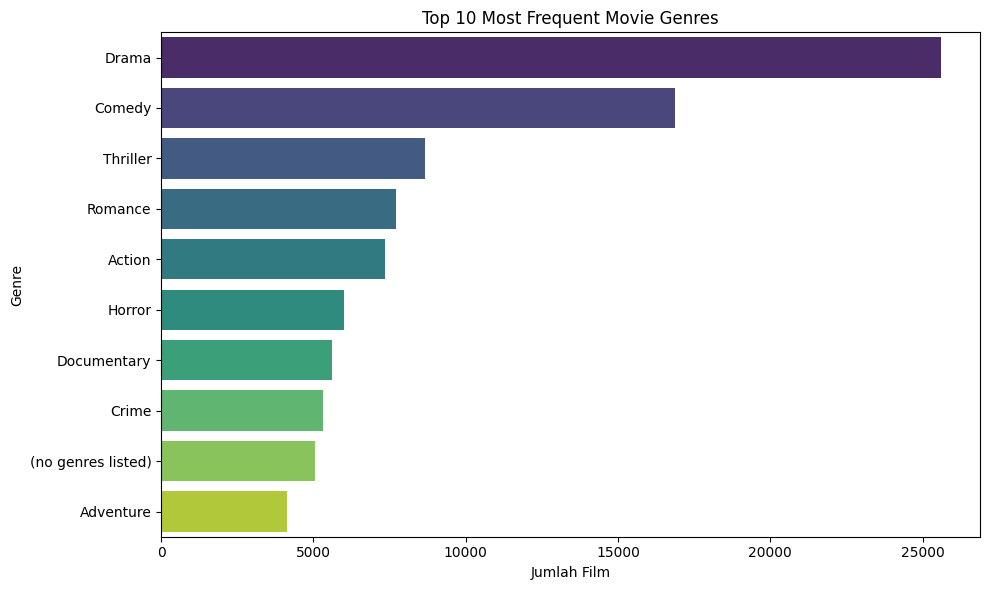

In [ ]:
# Pecah genre per baris
genre_split = movies['genres'].str.split('|').explode()

# Hitung frekuensi tiap genre
genre_counts = genre_split.value_counts().head(10)

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Top 10 Most Frequent Movie Genres')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

## **2. Ratings Variabel**
Melakukan pemeriksaan struktur data `ratings`, menampilkan beberapa data awal, serta menghitung statistik deskriptif dan jumlah unik pengguna, film, dan total data rating untuk memahami karakteristik variabel `ratings`.
Fungsi `ratings.info()` digunakan untuk menampilkan ringkasan struktur dataset:

- Total terdapat 25000095 data dan 4 kolom.
- Semua kolom bertipe numerik (int64 dan  float64).

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [ ]:
print('Jumlah userId: ', len(ratings.userId.unique()))
print('Jumlah moviesId: ', len(ratings.movieId.unique()))
print('Jumlah data rating: ', len(ratings))

Jumlah userId:  162541
Jumlah moviesId:  59047
Jumlah data rating:  25000095


In [ ]:
# Cek jumlah missing values per kolom
ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


In [ ]:
# Cek apakah ada baris duplikat
ratings.duplicated().sum()

np.int64(0)

### **Distribusi Skor Rating Film**
Berdasarkan visualisasi distribusi skor rating, diketahui bahwa tiga skor rating yang paling sering diberikan oleh pengguna adalah 4.0, 3.0, dan 5.0. Hal ini menunjukkan bahwa mayoritas pengguna cenderung memberikan penilaian yang positif hingga sangat positif terhadap film yang mereka tonton.

<ipython-input-17-0ae04dadd935>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings, x='rating', palette='mako', order=sorted(ratings['rating'].unique()))


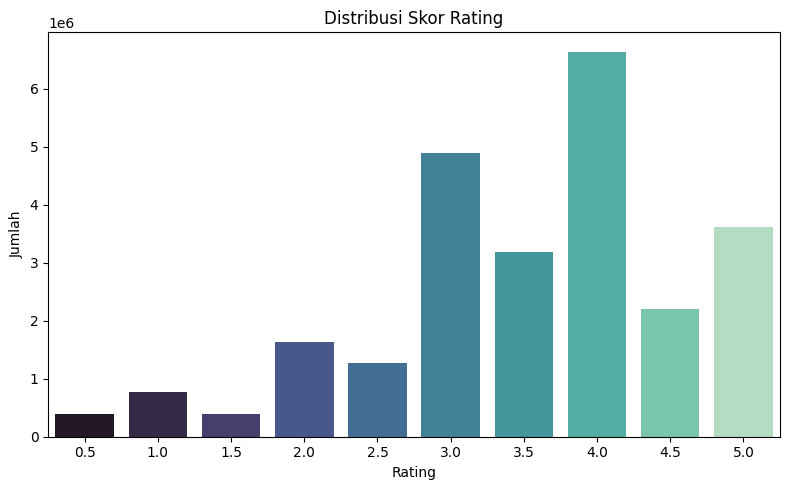

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=ratings, x='rating', palette='mako', order=sorted(ratings['rating'].unique()))
plt.title('Distribusi Skor Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

# Data Preprocessing

## **1. Menggabungkan dataset ratings dan movies berdasarkan kolom movieId**
Dilakukan penggabungan data ratings dan movies berdasarkan movieId menggunakan join kiri.
- Kolom timestamp dihapus karena tidak diperlukan dalam analisis.
- Data hasil penggabungan disimpan dalam variabel `df`.

In [ ]:
# Merge ratings sama movies berdasarkan movieId
df = pd.merge(ratings, movies, on='movieId', how='left')

# Hapus kolom yang tidak terpakai
df = df.drop(columns=['timestamp'])
df

,userId,movieId,rating,title,genres
0,1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,Underground (1995),Comedy|Drama|War
4,1,899,3.5,Singin' in the Rain (1952),Comedy|Musical|Romance
...,...,...,...,...,...
25000090,162541,50872,4.5,Ratatouille (2007),Animation|Children|Drama
25000091,162541,55768,2.5,Bee Movie (2007),Animation|Comedy
25000092,162541,56176,2.0,Alvin and the Chipmunks (2007),Children|Comedy
25000093,162541,58559,4.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX


## **2. Pengecekan Missing Value**
Dilakukan pengecekan nilai yang hilang (missing value) pada seluruh kolom dataframe df.

In [ ]:
# Mengecek missing value pada dataframe df
df.isnull().sum()

,0
userId,0
movieId,0
rating,0
title,0
genres,0


## **3. Pengurutan dan Pengambilan Sampel Data**
Data df diurutkan berdasarkan movieId secara menaik, kemudian diambil sampel sebanyak 100.000 baris secara acak untuk mengurangi penggunaan memori saat proses analisis selanjutnya.

In [ ]:
# Mengurutkan df berdasarkan movieId
df_fix = df.sort_values('movieId', ascending=True)

# Mengambil sample sebanyak 10000 baris agar tidak memakan banyak RAM
df_fix = df.sample(100000, random_state=42)
df_fix

,userId,movieId,rating,title,genres
15347762,99476,104374,3.5,About Time (2013),Drama|Fantasy|Romance
16647840,107979,2634,4.0,"Mummy, The (1959)",Horror
23915192,155372,1614,3.0,In & Out (1997),Comedy
10052313,65225,7153,4.0,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
12214125,79161,500,5.0,Mrs. Doubtfire (1993),Comedy|Drama
...,...,...,...,...,...
6065049,39304,2013,5.0,"Poseidon Adventure, The (1972)",Action|Adventure|Drama
19158221,124293,122904,3.0,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi
2120060,14163,7373,4.0,Hellboy (2004),Action|Adventure|Fantasy|Horror
21527407,139953,541,4.0,Blade Runner (1982),Action|Sci-Fi|Thriller


## **4. Mengecek Jumlah Film Unik dan Kategori Genre**
Menghitung jumlah film unik yang ada pada dataframe df_fix dan menampilkan kategori genre film yang terdapat pada data tersebut untuk memahami keberagaman data.

In [ ]:
# Mengecek berapa jumlah film unik di df_fix
len(df_fix.movieId.unique())

10262

In [ ]:
# Mengecek kategori genre yang unik di df_fix
df_fix.genres.unique()

array(['Drama|Fantasy|Romance', 'Horror', 'Comedy',
       'Action|Adventure|Drama|Fantasy', 'Comedy|Drama', 'Drama',
       'Adventure|Comedy|Crime', 'Children|Drama|Fantasy',
       'Horror|Thriller', 'Action|Adventure|Sci-Fi|Thriller',
       'Action|Drama|Romance|Sci-Fi', 'Drama|Mystery|Romance|Thriller',
       'Comedy|Fantasy|Romance', 'Sci-Fi', 'Crime|Drama',
       'Action|Adventure|Comedy|Fantasy|Horror|Thriller',
       'Children|Comedy|Fantasy', 'Adventure|Fantasy',
       'Adventure|Drama|Horror|Thriller', 'Action|Crime|Drama|Thriller',
       'Comedy|Horror|Thriller', 'Comedy|Romance', 'Crime|Drama|Thriller',
       'Action|Adventure|Fantasy', 'Crime|Drama|Mystery|Thriller',
       'Adventure|Animation|Children|Comedy|Fantasy', 'Action|Comedy',
       'Action|Sci-Fi', 'Action|Adventure|Comedy|Sci-Fi',
       'Action|Western', 'Adventure|Fantasy|Romance',
       'Action|Adventure|Sci-Fi', 'Drama|Mystery|Thriller',
       'Children|Musical', 'Adventure|Children|Comedy|Musica

## **5. Persiapan Data untuk Analisis Selanjutnya**
Membuat variabel preparation yang berisi dataframe df_fix dan mengurutkannya berdasarkan movieId.
Selanjutnya, data duplikat berdasarkan movieId dihapus untuk mendapatkan data film yang unik.

In [ ]:
# Membuat variabel preparation yang berisi dataframe df_fix kemudian mengurutkan berdasarkan movieId
preparation = df_fix
preparation.sort_values('movieId')

,userId,movieId,rating,title,genres
15775233,102159,1,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5464336,35423,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
21819641,141854,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2844627,18838,1,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
646684,4428,1,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
20666158,134386,205325,4.0,Jim Gaffigan: Quality Time (2019),Comedy
14122852,91534,205383,4.5,El Camino: A Breaking Bad Movie (2019),Crime|Drama|Thriller
7111045,46101,205857,3.0,Judy (2019),Drama|Romance
13255584,85805,206036,3.5,Into the Dark: Pure (2019),Horror


In [ ]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,title,genres
15347762,99476,104374,3.5,About Time (2013),Drama|Fantasy|Romance
16647840,107979,2634,4.0,"Mummy, The (1959)",Horror
23915192,155372,1614,3.0,In & Out (1997),Comedy
10052313,65225,7153,4.0,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
12214125,79161,500,5.0,Mrs. Doubtfire (1993),Comedy|Drama
...,...,...,...,...,...
1889854,12552,117360,5.0,Stiletto (2008),Action|Crime|Drama|Thriller
1956311,13011,3028,1.0,"Taming of the Shrew, The (1967)",Comedy
5987245,38796,4768,1.0,"Dr. Mabuse: The Gambler (Dr. Mabuse, der Spiel...",Crime|Mystery|Thriller
23627234,153348,5499,2.5,Robin and Marian (1976),Adventure|Drama|Romance


## **6. Konversi Data ke Bentuk List dan Membuat DataFrame Baru**
Data pada kolom `movieId`, `title`, dan `genres` diubah dari Series menjadi list untuk mempermudah pengolahan data selanjutnya.
Kemudian, list tersebut dikumpulkan kembali menjadi sebuah DataFrame baru dengan kolom `id`, `title`, dan `genre`.

In [ ]:
# Mengonversi data series 'movie_id' menjadi dalam bentuk list
movie_id = preparation['movieId'].tolist()

# Mengonversi data series 'movie_name' menjadi dalam bentuk list
movie_name = preparation['title'].tolist()

# Mengonversi data series 'movie_genre' menjadi dalam bentuk list
movie_genre = preparation['genres'].tolist()

print(len(movie_id))
print(len(movie_name))
print(len(movie_genre))

10262
10262
10262


In [ ]:
movie_new = pd.DataFrame({
    'id': movie_id,
    'title': movie_name,
    'genre': movie_genre
})
movie_new

,id,title,genre
0,104374,About Time (2013),Drama|Fantasy|Romance
1,2634,"Mummy, The (1959)",Horror
2,1614,In & Out (1997),Comedy
3,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
4,500,Mrs. Doubtfire (1993),Comedy|Drama
...,...,...,...
10257,117360,Stiletto (2008),Action|Crime|Drama|Thriller
10258,3028,"Taming of the Shrew, The (1967)",Comedy
10259,4768,"Dr. Mabuse: The Gambler (Dr. Mabuse, der Spiel...",Crime|Mystery|Thriller
10260,5499,Robin and Marian (1976),Adventure|Drama|Romance


In [ ]:
data = movie_new
data.sample(5)

,id,title,genre
1860,170697,Gifted (2017),Drama
7965,71187,"Pilgrim, The (1923)",Comedy
5354,132648,Honig im Kopf (2014),Comedy|Drama
9386,96020,Sidewalls (Medianeras) (2011),Drama
1756,933,To Catch a Thief (1955),Crime|Mystery|Romance|Thriller


# Model Development Content Based Filtering

## **1. Data Preparation**

In [ ]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data genre
tf.fit(data['genre'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

### **Preprocessing Genre**
Genre yang memiliki label tidak jelas seperti (no genres listed) diganti menjadi 'Unknown', dan format diseragamkan (contoh: 'Sci-Fi' diubah menjadi 'SciFi').

In [ ]:
# Cek film yang punya genre "no"
movie_new[movie_new['genre'].str.contains(r'\bno\b', case=False, regex=True)]

,id,title,genre
493,152171,Michael Jackson - Bad (1987),(no genres listed)
1163,141472,The 50 Year Argument (2014),(no genres listed)
1712,132549,Grandma (2015),(no genres listed)
2626,142616,The Furthest End Awaits (2014),(no genres listed)
2814,168312,Υπάρχει Και Φιλότιμο (1965),(no genres listed)
...,...,...,...
9832,147750,Rams (2015),(no genres listed)
9966,168806,The Other Side Of Hope (2017),(no genres listed)
10068,168908,Has the Film Already Started? (1951),(no genres listed)
10082,140874,Swallows and Amazons,(no genres listed)


In [ ]:
# Cek film yang punya genre "fi"
movie_new[movie_new['genre'].str.contains(r'\bfi\b', case=False, regex=True)]

,id,title,genre
10,61350,Babylon A.D. (2008),Action|Adventure|Sci-Fi|Thriller
11,2393,Star Trek: Insurrection (1998),Action|Drama|Romance|Sci-Fi
17,164179,Arrival (2016),Sci-Fi
35,2549,Wing Commander (1999),Action|Sci-Fi
36,737,Barb Wire (1996),Action|Sci-Fi
...,...,...,...
10206,91660,"Darkest Hour, The (2011)",Action|Horror|Sci-Fi|Thriller
10208,202103,I Am Mother (2019),Sci-Fi|Thriller
10218,2681,Free Enterprise (1998),Comedy|Romance|Sci-Fi
10229,142877,The Quiet Hour (2015),Drama|Sci-Fi|Thriller


In [ ]:
# Mengganti "no genres listed" menjadi "Unknown"
movie_new['genre'] = movie_new['genre'].replace('(no genres listed)', 'Unknown')
movie_new[movie_new['genre'].str.contains(r'Unknown', case=False, regex=True)]

,id,title,genre
493,152171,Michael Jackson - Bad (1987),Unknown
1163,141472,The 50 Year Argument (2014),Unknown
1712,132549,Grandma (2015),Unknown
2626,142616,The Furthest End Awaits (2014),Unknown
2814,168312,Υπάρχει Και Φιλότιμο (1965),Unknown
...,...,...,...
9832,147750,Rams (2015),Unknown
9966,168806,The Other Side Of Hope (2017),Unknown
10068,168908,Has the Film Already Started? (1951),Unknown
10082,140874,Swallows and Amazons,Unknown


In [ ]:
# Mengganti "Sci-Fi" menjadi "SciFi"
movie_new['genre'] = movie_new['genre'].str.replace('Sci-Fi', 'SciFi')
movie_new[movie_new['genre'].str.contains(r'SciFi', case=False, regex=True)]

,id,title,genre
10,61350,Babylon A.D. (2008),Action|Adventure|SciFi|Thriller
11,2393,Star Trek: Insurrection (1998),Action|Drama|Romance|SciFi
17,164179,Arrival (2016),SciFi
35,2549,Wing Commander (1999),Action|SciFi
36,737,Barb Wire (1996),Action|SciFi
...,...,...,...
10206,91660,"Darkest Hour, The (2011)",Action|Horror|SciFi|Thriller
10208,202103,I Am Mother (2019),SciFi|Thriller
10218,2681,Free Enterprise (1998),Comedy|Romance|SciFi
10229,142877,The Quiet Hour (2015),Drama|SciFi|Thriller


### **TF-IDF Vectorizer**
Data genre film diproses menggunakan TF-IDF Vectorizer untuk mengubah teks genre menjadi representasi numerik yang dapat digunakan dalam model rekomendasi berbasis konten.
- Genre diubah menjadi matriks TF-IDF dan dicek ukuran matriks hasil transformasi.
- Matriks TF-IDF dikonversi ke bentuk matriks padat (dense matrix) untuk memudahkan visualisasi.
- Dibuat DataFrame dari matriks TF-IDF dengan kolom genre dan baris nama film agar bisa dilihat nilai bobot TF-IDF pada masing-masing genre per film secara sampel.

In [ ]:
# Cek mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

In [ ]:
# Fit dan transform genre jadi matriks TF-IDF
tfidf_matrix = tf.fit_transform(data['genre'])

# Cek ukuran matriks
print(tfidf_matrix.shape)

(10262, 21)


In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.68398474, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre film
# Baris diisi dengan nama film

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.title
).sample(22, axis=1, replace=True).sample(10, axis=0)

,fantasy,horror,comedy,adventure,musical,film,western,adventure,horror,musical,...,mystery,thriller,unknown,imax,musical,drama,western,war,children,horror
title,,,,,,,,,,,,,,,,,,,,,
"Human Condition I, The (Ningen no joken I) (1959)",0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.385508,0.0,0.922705,0.0,0.000000
Larger Than Life (1996),0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
Timecop (1994),0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.510034,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
The Beat Beneath My Feet (2014),0.0,0.000000,0.761445,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.648230,0.0,0.000000,0.0,0.000000
Tristan & Isolde (2006),0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.527704,0.0,0.000000,0.0,0.000000
Slackers (2002),0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
"View to a Kill, A (1985)",0.0,0.000000,0.000000,0.635181,0.000000,0.0,0.0,0.635181,0.000000,0.000000,...,0.0,0.528713,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
Earth Girls Are Easy (1988),0.0,0.000000,0.346489,0.000000,0.744638,0.0,0.0,0.000000,0.000000,0.744638,...,0.0,0.000000,0.0,0.000000,0.744638,0.000000,0.0,0.000000,0.0,0.000000
Romeo Is Bleeding (1993),0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.642669,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


## **Modeling**

## **1. Cosine Similarity**
Melakukan perhitungan cosine similarity pada matriks TF-IDF untuk mengukur tingkat kemiripan antar film berdasarkan genre.
- Hasil cosine similarity disimpan dalam sebuah matriks persegi dan dikonversi menjadi DataFrame dengan indeks dan kolom berupa nama film.
- Matriks ini memperlihatkan seberapa mirip setiap film satu sama lain dari segi genre, yang nantinya berguna untuk sistem rekomendasi berbasis konten.

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.49158189,
        0.57275314],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.52685914],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.49158189, 0.        , 0.        , ..., 0.        , 1.        ,
        0.6200373 ],
       [0.57275314, 0.        , 0.52685914, ..., 0.        , 0.6200373 ,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama film
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap film
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (10262, 10262)


title,Henry V (1989),101 Dalmatians (1996),Quest for Camelot (1998),"Monkeyshines, No. 1 (1890)",Martyrs (2008)
title,,,,,
Talvar (2015),0.104314,0.000000,0.000000,0.000000,0.000000
"Eclisse, L' (Eclipse) (1962)",0.291108,0.000000,0.000000,0.000000,0.000000
Rams (2015),0.000000,0.000000,0.000000,0.000000,0.000000
"Pawnbroker, The (1964)",0.291108,0.000000,0.000000,0.000000,0.000000
Salem's Lot (1979),0.086967,0.000000,0.000000,0.000000,0.552211
Smurfs: The Lost Village (2017),0.000000,0.799954,0.700924,0.312251,0.000000
He Never Died (2015),0.120912,0.190443,0.000000,0.487894,0.767752
Klip (Clip) (2012),0.551650,0.000000,0.000000,0.000000,0.000000
"Asphalt Jungle, The (1950)",0.000000,0.000000,0.000000,0.000000,0.000000


## **2. Mendapatkan Rekomendasi**
Membuat fungsi movie_recommendations yang menerima input judul film dan mengembalikan daftar film rekomendasi berdasarkan kemiripan genre menggunakan cosine similarity.
- Fungsi ini mencari film dengan nilai similarity tertinggi terhadap film input.
- Hasil rekomendasi disajikan dalam bentuk DataFrame yang menyertakan nama film dan genre.
- Film yang sama dengan input dihilangkan agar tidak muncul di rekomendasi.

In [ ]:
def movie_recommendations(title, similarity_data=cosine_sim_df, items=movie_new[['title', 'genre']], k=5):
    """
    Rekomendasi film berdasarkan kemiripan genre film.

    Parameter:
    ---
    title : str
        Judul film yang mau dicari rekomendasinya (harus ada di index similarity dataframe)
    similarity_data : pd.DataFrame
        Dataframe kemiripan (cosine similarity) simetrik antar film
    items : pd.DataFrame
        Data film berisi nama film dan genre
    k : int
        Jumlah rekomendasi yang mau ditampilkan
    """

    # Ambil posisi k film dengan similarity terbesar ke title
    index = similarity_data.loc[:, title].to_numpy().argpartition(range(-1, -k-1, -1))

    # Ambil nama film dengan similarity tertinggi
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Hapus title agar tidak muncul di rekomendasi
    closest = closest.drop(title, errors='ignore')

    # Merge dengan data film asli biar dapet info genre dll
    return pd.DataFrame(closest, columns=['title']).merge(items, on='title').head(k)

In [ ]:
data[data.title.eq('Butter (2011)')]

,id,title,genre
5922,97311,Butter (2011),Comedy


In [ ]:
# Mendapatkan rekomendasi film yang mirip
movie_recommendations('Butter (2011)')

,title,genre
0,Meatballs III (1987),Comedy
1,Serial (1980),Comedy
2,"Specials, The (2000)",Comedy
3,How to Stuff a Wild Bikini (1965),Comedy
4,Blackadder Back & Forth (1999),Comedy


## **3. Hasil Evaluasi**
Model content-based filtering memberikan rekomendasi berdasarkan kesamaan fitur antar film, khususnya genre. Misalnya, ketika pengguna memilih film Butter (2011) yang bergenre Comedy, sistem memberikan lima rekomendasi film lain yang juga bergenre Comedy:
- Meatballs III (1987)
- Serial (1980)
- Specials, The (2000)
- How to Stuff a Wild Bikini (1965)
- Blackadder Back & Forth (1999)

Kelima film memiliki genre yang relevan dengan film yang dipilih.

**Kesimpulan:**
Model content-based filtering menunjukkan performa yang sangat baik dalam menjaga konsistensi genre dalam rekomendasinya. Precision@5 yang mencapai 100% menunjukkan bahwa sistem ini efektif dalam merekomendasikan film dengan karakteristik yang serupa, cocok untuk pengguna dengan preferensi genre yang spesifik.

# Model Development dengan Collaborative Filtering
Pengembangan model rekomendasi berbasis collaborative filtering menggunakan data rating film.
- Dataset ratings disampling sebanyak 100.000 baris agar tidak memakan banyak RAM.

In [ ]:
# Membaca dataset
df = ratings
df = df.sample(100000, random_state=42)
df

,userId,movieId,rating,timestamp
15347762,99476,104374,3.5,1467897440
16647840,107979,2634,4.0,994007728
23915192,155372,1614,3.0,1097887531
10052313,65225,7153,4.0,1201382275
12214125,79161,500,5.0,1488915363
...,...,...,...,...
6065049,39304,2013,5.0,941833377
19158221,124293,122904,3.0,1468201515
2120060,14163,7373,4.0,1134913713
21527407,139953,541,4.0,1071502175


## **Data Preparation**

## **1. Encoding**
- Proses encoding `userId` dan `movieId` ke angka agar mudah diproses model.
- Mengambil list `userId` dan `movieId` unik.
- Membuat dictionary untuk mapping `userId` dan `movieId` ke angka dan sebaliknya (encode dan decode).
- Menambahkan kolom baru `user` dan `movie` pada DataFrame hasil mapping tersebut.

In [ ]:
# Mengubah userID menjadi list unik
user_ids = df['userId'].unique().tolist()
print('list userId:', user_ids)

# Encode userID jadi angka
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId:', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId:', user_encoded_to_user)

list userId: [99476, 107979, 155372, 65225, 79161, 105342, 68169, 21378, 133938, 151798, 148300, 116498, 148324, 87735, 89910, 121214, 155715, 154793, 45394, 71952, 156793, 138596, 25474, 126001, 65274, 122955, 8775, 122803, 84055, 28436, 144139, 92366, 76183, 27171, 98776, 117106, 47496, 151537, 117415, 30915, 114062, 55386, 86723, 30017, 20040, 146376, 29664, 120986, 151734, 29347, 42785, 93784, 82983, 119067, 110364, 59943, 6713, 35327, 94219, 111072, 138575, 36671, 1535, 76766, 15315, 57432, 135038, 57477, 61809, 121380, 49853, 5376, 1553, 48672, 82541, 111887, 129817, 48133, 140224, 97576, 38562, 142380, 84467, 75558, 67799, 95169, 157719, 139294, 80809, 95416, 63184, 108053, 152597, 22771, 15553, 112225, 102158, 15794, 50659, 25506, 146060, 148265, 58555, 23267, 135241, 45693, 13551, 38369, 158964, 150690, 13011, 13570, 110622, 124443, 26985, 4909, 97566, 161492, 33952, 43984, 126670, 133083, 100260, 109175, 93884, 89054, 59122, 90020, 116321, 98503, 140569, 6729, 22418, 117221, 

In [ ]:
# Mengubah movieId menjadi list unik
movie_ids = df['movieId'].unique().tolist()

# Encoding movieId → angka
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Decoding angka → movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

In [ ]:
# Mapping userId dan movieId ke bentuk encoded
df['user'] = df['userId'].map(user_to_user_encoded)
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

##**2. Pemeriksaan dan Informasi Dataset Setelah Encoding**
Melakukan pemeriksaan hasil mapping userId dan movieId ke angka:
- Menampilkan contoh mapping pada beberapa baris awal.
- Menghitung jumlah user unik dan movie unik setelah encoding.
- Mengubah tipe data rating menjadi float32 untuk efisiensi komputasi.
- Mengambil nilai rating minimum dan maksimum sebagai informasi rentang rating.

In [ ]:
# Cek hasil mapping
df[['userId', 'user', 'movieId', 'movie']].head()

,userId,user,movieId,movie
15347762,99476,0,104374,0
16647840,107979,1,2634,1
23915192,155372,2,1614,2
10052313,65225,3,7153,3
12214125,79161,4,500,4


In [ ]:
# Jumlah user unik (yang udah di-encode)
num_users = len(user_to_user_encoded)
print("Jumlah user:", num_users)

# Jumlah movie unik (yang udah di-encode)
num_movies = len(movie_encoded_to_movie)
print("Jumlah movie:", num_movies)

# Convert rating ke float32
df['rating'] = df['rating'].values.astype(np.float32)

# Ambil min & max rating
min_rating = df['rating'].min()
max_rating = df['rating'].max()

print('Number of Users: {}, Number of Movies: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

Jumlah user: 55057
Jumlah movie: 10262
Number of Users: 55057, Number of Movies: 10262, Min Rating: 0.5, Max Rating: 5.0


## **3. Membagi Data untuk Training dan Validasi**
Melakukan persiapan data sebelum masuk ke model training:
- Dataset diacak supaya distribusi data acak dan gak bias.
- Fitur input berupa kombinasi user dan movie dalam bentuk array.
- Target (rating) dinormalisasi ke rentang 0 sampai 1 supaya model lebih gampang belajar dan stabil.
- Data dibagi jadi 2: 80% untuk training, 20% untuk validasi performa model.
- Cetak bentuk data (shape) untuk memastikan ukuran data sudah benar.

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie
8367039,54508,3176,3.0,1491794651,14502,2311
10153525,65861,858,5.0,1217869145,9328,486
10229123,66321,7454,2.0,1432824940,16581,688
10834799,70318,53121,4.0,1567793679,28419,3621
23571178,152991,1084,3.0,1216431532,52601,483
...,...,...,...,...,...,...
3413498,22515,1580,3.5,1493443641,5864,227
5863225,37980,7361,1.5,1558145081,36763,1207
2422258,16167,333,4.0,1309709358,29585,1197
21757612,141460,1225,3.0,1076769760,853,690


In [ ]:
# Gabung user & movie jadi satu array
x = df[['user', 'movie']].values

# Normalisasi rating ke range 0-1 biar cocok buat training
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Split 80% buat training, 20% buat validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# Buat ngecek bentuknya
print("x shape:", x.shape)
print("y shape:", y.shape)
print(x, y)

x shape: (100000, 2)
y shape: (100000,)
[[14502  2311]
 [ 9328   486]
 [16581   688]
 ...
 [29585  1197]
 [  853   690]
 [10931  1689]] [0.55555556 1.         0.33333333 ... 0.77777778 0.55555556 0.88888889]


## **Modeling**

## **1. Proses Training**
- Membangun Arsitektur Model RecommenderNet
Model ini pake embedding buat representasi user dan movie dalam ruang vektor berdimensi kecil (embedding size = 50).
Ada 2 embedding:
  - User embedding + bias user
  - Movie embedding + bias movie

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Arsitektur model rekomendasi
class RecommenderNet(tf.keras.Model):

    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        # Embedding user
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        # Embedding movie
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias

        return tf.nn.sigmoid(x)

**Inisialisasi dan Compile Model**
- Loss function: BinaryCrossentropy (karena rating sudah dinormalisasi ke 0-1, diperlakukan kayak klasifikasi biner).
- Optimizer: Adam dengan learning rate 0.001.
- Metrics: Root Mean Squared Error (RMSE) untuk evaluasi kesalahan prediksi.

**Training Model**
- Batch size kecil (8) supaya update model lebih sering.
- Latih selama 50 epoch menggunakan data validasi untuk cek performa model selama training.

In [ ]:
# Inisialisasi model
model = RecommenderNet(num_users, num_movies, embedding_size=50)

# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Training model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=50,
    validation_data=(x_val, y_val)
)

Epoch 1/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 457s 46ms/step - loss: 0.6771 - root_mean_squared_error: 0.2791 - val_loss: 0.6424 - val_root_mean_squared_error: 0.2459
Epoch 2/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 487s 49ms/step - loss: 0.6183 - root_mean_squared_error: 0.2202 - val_loss: 0.6308 - val_root_mean_squared_error: 0.2336
Epoch 3/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 528s 51ms/step - loss: 0.6090 - root_mean_squared_error: 0.2111 - val_loss: 0.6254 - val_root_mean_squared_error: 0.2285
Epoch 4/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 534s 48ms/step - loss: 0.6003 - root_mean_squared_error: 0.2008 - val_loss: 0.6217 - val_root_mean_squared_error: 0.2250
Epoch 5/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 499s 48ms/step - loss: 0.5942 - root_mean_squared_error: 0.1960 - val_loss: 0.6191 - val_root_mean_squared_error: 0.2226
Epoch 6/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 490s 49ms/step - loss: 0.5881 - root_mean_squared_error: 0.1884 - val_loss: 0.6172 - val_root_mean_squared_error: 0.2208
Epoch 7/50

**Visualisasi Training**
- Plot grafik RMSE training dan validasi per epoch untuk untuk mengukur performa model dalam memprediksi nilai numerik.

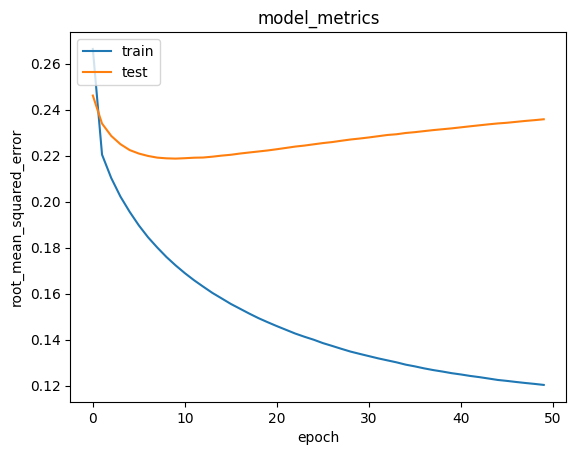

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **2. Mendapatkan Rekomendasi Film**
- Ambil satu user secara acak dari data rating.
- Identifikasi film yang belum ditonton oleh user tersebut.
- Prediksi rating untuk film yang belum ditonton menggunakan model.
- Ambil 10 film dengan prediksi rating tertinggi sebagai rekomendasi.
- Tampilkan 5 film favorit user dan 10 rekomendasi terbaik berdasarkan hasil prediksi.

In [ ]:
movie_df = data
df = pd.read_csv('ratings.csv')  # dataset rating user terhadap film

# Ambil sample user random
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]

# Ambil film yang belum ditonton user
movies_not_watched = movie_df[~movie_df['id'].isin(movies_watched_by_user.movieId.values)]['id']
movies_not_watched = list(
    set(movies_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movies_not_watched = [[movie_to_movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

In [ ]:
# Prediksi rating buat film yang belum ditonton
ratings = model.predict(user_movie_array).flatten()

# Ambil top 10 rekomendasi
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for user:', user_id)
print('===' * 9)
print('Movies with high ratings from user')
print('----' * 8)

# Tampilkan film yang paling tinggi rating-nya dari user itu
top_movies_user = (
    movies_watched_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['id'].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, '-', row.genre)

print('----' * 8)
print('Top 10 movie recommendations')
print('----' * 8)

recommended_movies = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, '-', row.genre)

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Showing recommendations for user: 69840
Movies with high ratings from user
--------------------------------
Forrest Gump (1994) - Comedy|Drama|Romance|War
Shawshank Redemption, The (1994) - Crime|Drama
Blind Side, The  (2009) - Drama
Green Mile, The (1999) - Crime|Drama
Sleepers (1996) - Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Four Days in September (O Que É Isso, Companheiro?) (1997) - Drama
My Beautiful Laundrette (1985) - Drama|Romance
Ikiru (1952) - Drama
Fresh (1994) - Crime|Drama|Thriller
Hannah Arendt (2012) - Drama
Raiders of the Lost Ark: The Adaptation (1989) - Action|Adventure|Thriller
Beautiful Thing (1996) - Drama|Romance
Jude (1996) - Drama
Nikitich and The Dragon (2006) - Adventure|Animation|Comedy|Drama|Fantasy
Summer with Monika (Sommaren med Monika) (1953) - Drama|Romance


## **3. Hasil Evaluasi**
- Nilai RMSE pada data pelatihan akhir: sekitar 0.12
- Nilai RMSE pada data validasi: sekitar 0.23
- Kisaran RMSE selama pelatihan: 0.12 – 0.26
Model collaborative filtering menunjukkan proses pelatihan yang stabil dan konvergen pada sekitar epoch ke-50. Nilai RMSE yang cukup rendah menunjukkan bahwa model mampu memprediksi rating pengguna dengan akurasi yang baik.

**Kesimpulan:**
Dengan hasil RMSE yang rendah, model collaborative filtering terbukti efektif dalam memahami pola preferensi pengguna berdasarkan interaksi historis. Model ini sangat berguna dalam memberikan prediksi rating yang akurat, yang menjadi dasar dalam menyusun daftar rekomendasi.